In [1]:
# main.py
import numpy as np
import matplotlib.pyplot as plt
import config
from preprocessing import load_and_preprocess
from kde import CustomKDE

In [ ]:
def create_dummy_data():
    """
    Helper to create dummy images if you don't have files.
    Background: Mostly blue.
    Test: Blue background with a Red square (foreground).
    """
    bg = np.zeros((100, 100, 3), dtype=np.uint8)
    bg[:] = (255, 0, 0) # Blue background (OpenCV uses BGR, but we convert to RGB later)
    # Add some noise
    noise = np.random.randint(0, 20, (100, 100, 3))
    bg = np.clip(bg + noise, 0, 255).astype(np.uint8)
    
    test = bg.copy()
    # Add a red square (Foreground)
    test[30:70, 30:70] = (0, 0, 255) 
    
    import cv2
    cv2.imwrite('background.jpg', bg)
    cv2.imwrite('test_image.jpg', test)
    print("Dummy images created.")

In [3]:
try:
    open(config.BG_IMAGE_PATH)
except FileNotFoundError:
        create_dummy_data()

In [4]:
# --- 1.1 Image Pre-Processing ---
print("Loading and preprocessing images...")
bg_img, bg_features = load_and_preprocess(
        config.BG_IMAGE_PATH, 
        config.IMG_SIZE, 
        config.FEATURE_TYPE
)

test_img, test_features = load_and_preprocess(
        config.TEST_IMAGE_PATH, 
        config.IMG_SIZE, 
        config.FEATURE_TYPE
)

Loading and preprocessing images...


In [5]:
   # --- 1.2 KDE Model Initialization & Fitting ---c
print(f"Initializing KDE with Kernel: {config.KERNEL_TYPE}, Bandwidth: {config.BANDWIDTH}")
kde = CustomKDE(kernel=config.KERNEL_TYPE, bandwidth=config.BANDWIDTH)
    
print("Fitting model to background...")
# We use sample_ratio to implement the 'Smart Sampling' requirement
kde.fit(bg_features, sample_ratio=config.SAMPLE_RATIO)

# --- 1.3 Foreground Detection (Prediction) ---
print("Predicting densities for test image...")
densities = kde.predict(test_features)
    
# Reshape densities back to image shape (H, W)
density_map = densities.reshape(config.IMG_SIZE[1], config.IMG_SIZE[0])

# Classification / Thresholding
# Pixels with LOW probability (density < threshold) are Foreground
# Pixels with HIGH probability are Background
foreground_mask = density_map < config.THRESHOLD

Initializing KDE with Kernel: gaussian, Bandwidth: 0.2
Fitting model to background...
KDE Fitted with 1000 samples (Dimensions: 3)
Predicting densities for test image...


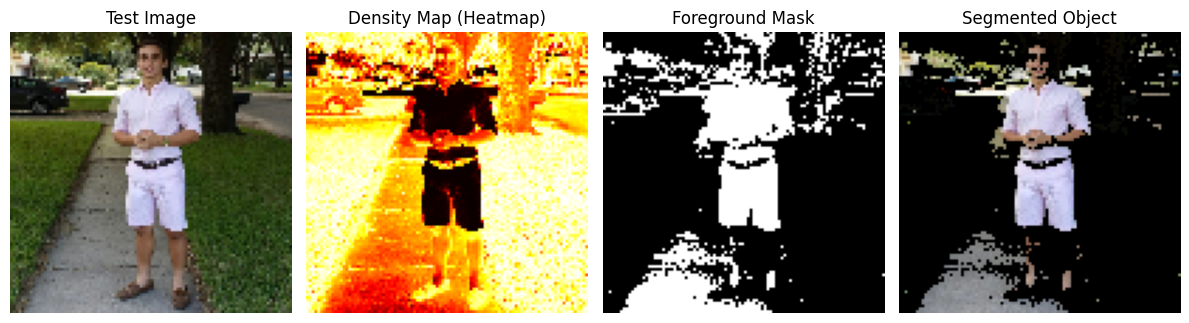

In [6]:
 # --- Visualization ---
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 4, 1)
plt.title("Test Image")
plt.imshow(test_img)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Density Map (Heatmap)")
plt.imshow(density_map, cmap='hot')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Foreground Mask")
plt.imshow(foreground_mask, cmap='gray')
plt.axis('off')
    
plt.subplot(1, 4, 4)
plt.title("Segmented Object")
    # Apply mask to original image
segmented = test_img.copy()
segmented[~foreground_mask] = 0 # Set background to black
plt.imshow(segmented)
plt.axis('off')

plt.tight_layout()
plt.show()